# Importing Libraries

In [1]:
from tensorflow.keras.models import model_from_json
from fer_model import get_fer_model
import tensorflow as tf
import tempfile 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.optimizers import Adam

import os
import zipfile

import tensorflow_model_optimization as tfmot
import pickle

In [2]:
import time
TIMESTAMP = round(time.time())
print("Timestamp is", TIMESTAMP)
SPARSITY = 0.1

Timestamp is 1619011512


In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Loading the CK+ Dataset

In [4]:
from data import load_ckplus
train_generator = load_ckplus("train")
test_generator = load_ckplus("test")

Found 924 images belonging to 8 classes.
Found 384 images belonging to 8 classes.


# Load Baseline Model

In [5]:
model = get_fer_model()
model.load_weights("weights/model_weights_1618972642.h5")

In [6]:
from evaluation import get_metrics

print("Baseline model performance:")
get_metrics(model, test_generator)

Baseline model performance:


{'size': 16512046,
 'acc': 0.6796875,
 'f_acc': 0.6708333333333333,
 'm_acc': 0.6944444444444444,
 'f_acc_breakdown': [0.5333333333333333,
  0.48484848484848486,
  1.0,
  0.7083333333333334,
  0.7142857142857143,
  0.9,
  0.2,
  0.8666666666666667],
 'f_acc_balanced': 0.6759334415584417,
 'm_acc_breakdown': [0.4166666666666667,
  0.4166666666666667,
  1.0,
  0.9523809523809523,
  0.0,
  0.75,
  0.3333333333333333,
  1.0],
 'm_acc_balanced': 0.6086309523809523}

# Apply Pruning

In [7]:
def prune(model, sparsity=0.8):
    
    epochs = 2
    
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
            sparsity, 0, end_step=-1, frequency=32
        )
    }
    model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    opt = Adam(lr=0.0005)
    model_for_pruning.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fine-Tuning 
    logdir = tempfile.mkdtemp()
    print("Saving logs to:", logdir)

    steps_per_epoch = train_generator.n//train_generator.batch_size
    validation_steps = test_generator.n//test_generator.batch_size

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=2, min_lr=0.00001, mode='auto')
    checkpoint_name = "weights/pruned_model_weights_s%d_%s.h5" % (sparsity*100, TIMESTAMP)
    checkpoint = ModelCheckpoint(checkpoint_name, 
                                 monitor='val_accuracy', 
                                 save_weights_only=True,
                                 save_best_only=True,
                                 mode='max', verbose=1)
    callbacks = [PlotLossesKerasTF(), 
                 checkpoint, 
                 reduce_lr, 
                 tfmot.sparsity.keras.UpdatePruningStep(),
                 tfmot.sparsity.keras.PruningSummaries(log_dir=logdir)]

    model_for_pruning.fit(
        x=train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data = test_generator,
        validation_steps = validation_steps,
        callbacks=callbacks
    )
    
    # Only use the best weights 
    model_for_pruning.load_weights(checkpoint_name)
    model_for_pruning = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
    model_for_pruning.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model_for_pruning

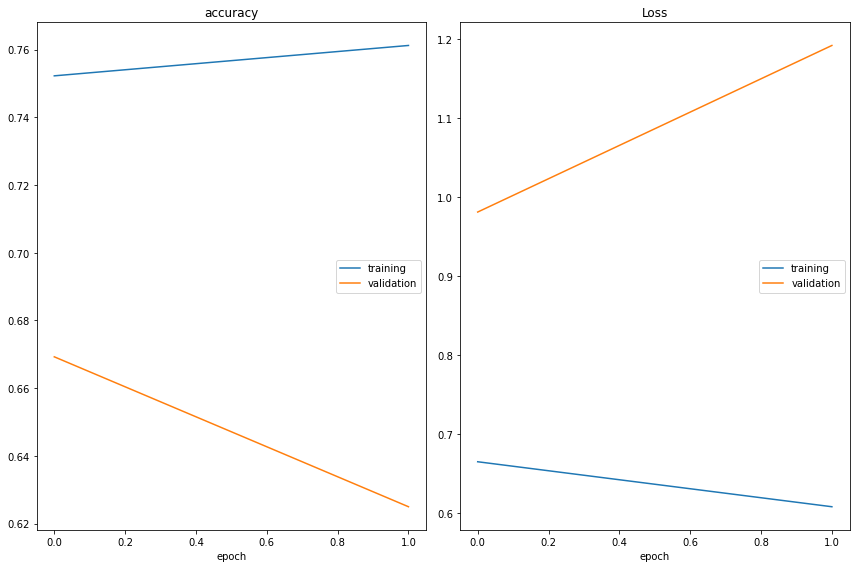

accuracy
	training         	 (min:    0.752, max:    0.761, cur:    0.761)
	validation       	 (min:    0.625, max:    0.669, cur:    0.625)
Loss
	training         	 (min:    0.608, max:    0.665, cur:    0.608)
	validation       	 (min:    0.981, max:    1.192, cur:    1.192)

Epoch 00002: val_accuracy did not improve from 0.66927
28/28 [==============================] - 25s 898ms/step - loss: 0.6080 - accuracy: 0.7612 - val_loss: 1.1916 - val_accuracy: 0.6250


In [8]:
pruned_model = prune(model, sparsity=SPARSITY)

# Evaluate Pruned Model

In [9]:
print("Model performance after pruning:")
metrics = get_metrics(pruned_model, test_generator)
metrics

Model performance after pruning:


{'size': 15551814,
 'acc': 0.6692708333333334,
 'f_acc': 0.5958333333333333,
 'm_acc': 0.7916666666666666,
 'f_acc_breakdown': [0.7333333333333333,
  0.30303030303030304,
  0.25,
  0.6666666666666666,
  0.14285714285714285,
  0.8,
  0.2,
  0.8888888888888888],
 'f_acc_balanced': 0.4980970418470419,
 'm_acc_breakdown': [0.6944444444444444,
  0.0,
  1.0,
  1.0,
  0.0,
  0.9583333333333334,
  0.6666666666666666,
  1.0],
 'm_acc_balanced': 0.6649305555555556}

### Store results

In [10]:
with open("logs/pruned_model_metrics_s%d_%s" % (SPARSITY*100, TIMESTAMP), 'wb') as pruned_model_metrics_file:
        pickle.dump(metrics, pruned_model_metrics_file)

# Apply Quantisation to the Pruned Model 

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
# This optimisation includes the quantisation 
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

# Evaluate Pruned and Quantised Model

In [12]:
from evaluation import get_metrics_quantised
metrics = get_metrics_quantised(quantized_and_pruned_tflite_model, test_generator)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.


In [13]:
print("Pruned and quantised model performance:")
metrics

Pruned and quantised model performance:


{'size': 3922027,
 'acc': 0.6692708333333334,
 'f_acc': 0.5958333333333333,
 'm_acc': 0.7916666666666666,
 'f_acc_breakdown': [0.7333333333333333,
  0.30303030303030304,
  0.25,
  0.6666666666666666,
  0.14285714285714285,
  0.8,
  0.2,
  0.8888888888888888],
 'f_acc_balanced': 0.4980970418470419,
 'm_acc_breakdown': [0.6944444444444444,
  0.0,
  1.0,
  1.0,
  0.0,
  0.9583333333333334,
  0.6666666666666666,
  1.0],
 'm_acc_balanced': 0.6649305555555556}

### Store results

In [14]:
with open("logs/pruned_and_quantised_model_metrics_s%d_%s" % (SPARSITY*100, TIMESTAMP), 
          'wb') as pruned_and_quantised_model_metrics_file:
        pickle.dump(metrics, pruned_and_quantised_model_metrics_file)